# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helper
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from functools import reduce
import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import mplfinance as mpf
import pandas_ta as pta
import talib.abstract as ta
import random

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

import freqtrade.vendor.qtpylib.indicators as qtpylib

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"

# Define custom functions
def get_random_index(dataframe: pd.DataFrame, loc_condition):
    idx = 0
    while idx < 100 or idx > len(dataframe) - 100:
        idx = dataframe.loc[loc_condition].sample()["idx"][0]
    return idx


def get_middle(dataframe: pd.DataFrame, index: int, num_look: int) -> pd.DataFrame:
    return dataframe.loc[
        (dataframe["idx"] >= index - num_look) & (dataframe["idx"] <= index + num_look)
    ]


style = {'base_mpl_style': 'fast',
         'marketcolors'  : {'candle': {'up': '#00b060', 'down': '#fe3032'},
                            'edge'  : {'up': '#00b060', 'down': '#fe3032'},
                            'wick'  : {'up': '#606060', 'down': '#606060'},
                            'ohlc'  : {'up': '#00b060', 'down': '#fe3032'},
                            'volume': {'up': '#4dc790', 'down': '#fd6b6c'},
                            'vcedge': {'up': '#1f77b4', 'down': '#1f77b4'},
         'vcdopcod'      : True,
         'alpha'         : 0.9},
         'mavcolors'     : None,
         'facecolor'     : '#fafafa',
         'gridcolor'     : '#d0d0d0',
         'gridstyle'     : '-',
         'y_on_right'    : True,
         'rc'            : {'axes.labelcolor': '#101010',
                            'axes.grid.axis' : 'y',
                            'ytick.color'    : '#101010',
                            'xtick.color'    : '#101010',
                            'figure.titlesize': 'x-large',
                            'figure.titleweight':'semibold',
                            'axes.edgecolor'  : 'black',
                           'axes.linewidth'  :  1.0,
                           'lines.linewidth' :  1.0,
                           },
         'base_mpf_style': 'yahoo'}


def plot(dataframe: pd.DataFrame, display_indicators: dict, draw_signals: bool, length = 150):
    """ Plot the price chart!
    """
    df = dataframe.copy()[-length:]
    
    addplot = []
    kwargs = {}
    
    if draw_signals:
        df.loc[df["buy"] == 1, "buy"] = df["low"] - (0.0025*df["low"])
        df.loc[df["buy"] == 0, "buy"] = np.nan
        df.loc[df["sell"] == 1, "sell"] = df["high"] + (0.0025*df["high"])
        df.loc[df["sell"] == 0, "sell"] = np.nan
        
        # Add buy and sell markers
        if len(df.loc[df["buy"] > 0]) > 0: 
            addplot.append(mpf.make_addplot(df["buy"], type='scatter', markersize=100, marker='^', color="green"))
        if len(df.loc[df["sell"] > 0]) > 0: 
            addplot.append(mpf.make_addplot(df["sell"], type='scatter', markersize=100, marker='v', color="red"))
    
        # Add vline markers
        df.index = pd.to_datetime(df.index)
        kwargs["vlines"] = {
            "vlines": list(df.loc[df["buy"] > 0].index) + list(df.loc[df["sell"] > 0].index),
            "alpha": 0.25,
            "colors": ["green" for _ in range(len(df.loc[df["buy"] > 0]))] + ["red" for _ in range(len(df.loc[df["sell"] > 0]))]
        }
    
    for indicator, opt in display_indicators.items():
        _kwargs = {}
        
        if opt["type"] != "line":
            _kwargs["type"] = opt["type"]
        
        plot = mpf.make_addplot(
            df[indicator], 
            color=opt["color"], 
            panel=opt["panel"], 
            ylabel=indicator, 
            **_kwargs
        )
        
        addplot.append(plot)
    
    mpf.plot(
        df, 
        type="candle", 
        style=style, 
        figsize=(15, 8), 
        addplot=addplot,
        **kwargs,
    )
    
def process_df_pop(_df_pop: pd.DataFrame) -> pd.DataFrame:
    len_buy, len_sell = len(_df_pop.loc[_df_pop["buy"] == 1]), len(_df_pop.loc[_df_pop["sell"] == 1])
    print(f"Buy signals: {len_buy} | Sell signals: {len_sell}")
    if len_buy == 0: raise Exception("Zero BUY signals")
    if len_sell == 0: raise Exception("Zero SELL signals")
    idx_buy, idx_sell = get_random_index(_df_pop, _df_pop["buy"] == 1), get_random_index(_df_pop, _df_pop["sell"] == 1)
    print(f"Index BUY: {idx_buy} | Index SELL: {idx_sell}")
    look_len = 70
    if random.randint(0, 1) == 0: 
        print("Showing SELL example")
        df_middle = get_middle(_df_pop, idx_sell, look_len)
    else:
        print("Showing BUY example")
        df_middle = get_middle(_df_pop, idx_buy, look_len)
    return df_middle
    

env: WANDB_SILENT=true


# Build Any Strategy

In [2]:
timeframe = "15m"
df_load = loader.load_df(PATH_DATA / "binance"/ f"BTC_USDT-{timeframe}.json", timeframe).iloc[-100000:]
df_load = df_load.set_index("date")
df_load["idx"] = range(0, len(df_load))
df_load["buy"] = 0
df_load["sell"] = 0
df_load

,open,high,low,close,volume,idx,buy,sell
date,,,,,,,,
2018-10-18 12:30:00+00:00,6719.99,6722.00,6712.00,6722.00,319.165441,0,0,0
2018-10-18 12:45:00+00:00,6722.00,6725.00,6713.01,6717.41,415.551896,1,0,0
2018-10-18 13:00:00+00:00,6718.94,6724.42,6715.00,6719.99,272.932829,2,0,0
2018-10-18 13:15:00+00:00,6719.99,6723.43,6703.33,6710.05,244.234848,3,0,0
2018-10-18 13:30:00+00:00,6708.11,6718.48,6708.10,6714.00,174.064040,4,0,0
...,...,...,...,...,...,...,...,...
2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,99995,0,0
2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,99996,0,0
2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,99997,0,0


In [3]:
def populate_indicators(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Populate Freqtrade Indicators """
    dataframe["dema"] = pta.dema(dataframe["close"], length=1000)
    supertrend = pta.supertrend(
        high=dataframe["high"], low=dataframe["low"], close=dataframe["close"], length=12, multiplier=3
    )
    dataframe[supertrend.columns] = supertrend
    return dataframe


def populate_buy_trend(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Generate BUY Signals"""
    conditions = [
        # Trigger
        (
            qtpylib.crossed_above(dataframe["close"], dataframe["SUPERT_12_3.0"])
        ),
        # Filter
        dataframe["close"] > dataframe['dema'],
        dataframe['volume'] > 0,
    ]
            
    dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
    return dataframe

    
def populate_sell_trend(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Generate SELL Signals"""
    conditions = [
        qtpylib.crossed_below(dataframe["close"], dataframe["SUPERT_12_3.0"]),
        dataframe['volume'] > 0,
    ]
            
    dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
    return dataframe


df_pop = populate_sell_trend(populate_buy_trend(populate_indicators(df_load.copy())))
df_pop

,open,high,low,close,volume,idx,buy,sell,dema,SUPERT_12_3.0,SUPERTd_12_3.0,SUPERTl_12_3.0,SUPERTs_12_3.0
date,,,,,,,,,,,,,
2018-10-18 12:30:00+00:00,6719.99,6722.00,6712.00,6722.00,319.165441,0,0,0,NaN,0.000000,1,NaN,NaN
2018-10-18 12:45:00+00:00,6722.00,6725.00,6713.01,6717.41,415.551896,1,0,0,NaN,NaN,1,NaN,NaN
2018-10-18 13:00:00+00:00,6718.94,6724.42,6715.00,6719.99,272.932829,2,0,0,NaN,NaN,1,NaN,NaN
2018-10-18 13:15:00+00:00,6719.99,6723.43,6703.33,6710.05,244.234848,3,0,0,NaN,NaN,1,NaN,NaN
2018-10-18 13:30:00+00:00,6708.11,6718.48,6708.10,6714.00,174.064040,4,0,0,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,99995,0,0,49528.612794,48437.543662,-1,NaN,48437.543662
2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,99996,0,0,49527.224815,48437.543662,-1,NaN,48437.543662
2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,99997,0,0,49524.978121,48437.543662,-1,NaN,48437.543662


Buy signals: 500 | Sell signals: 984
Index BUY: 58956 | Index SELL: 36322
Showing BUY example


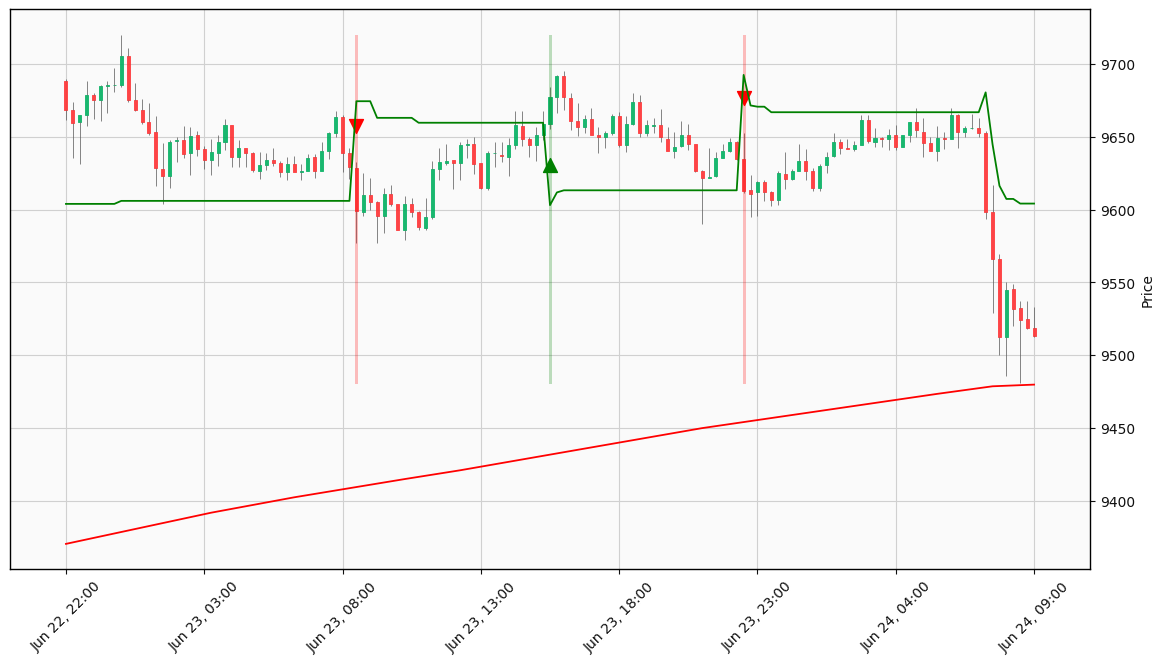

In [4]:
df_middle = process_df_pop(df_pop)

display_indicators = {
    "dema":          {"panel": 0, "color": "red", "type": "line"},
    "SUPERT_12_3.0": {"panel": 0, "color": "green", "type": "line"},
} 
# Type: `line` or `bar`
# Panel: 0 for overlaps like MA, 1..2..3... for extra panel below

plot(df_middle, display_indicators, draw_signals=True)

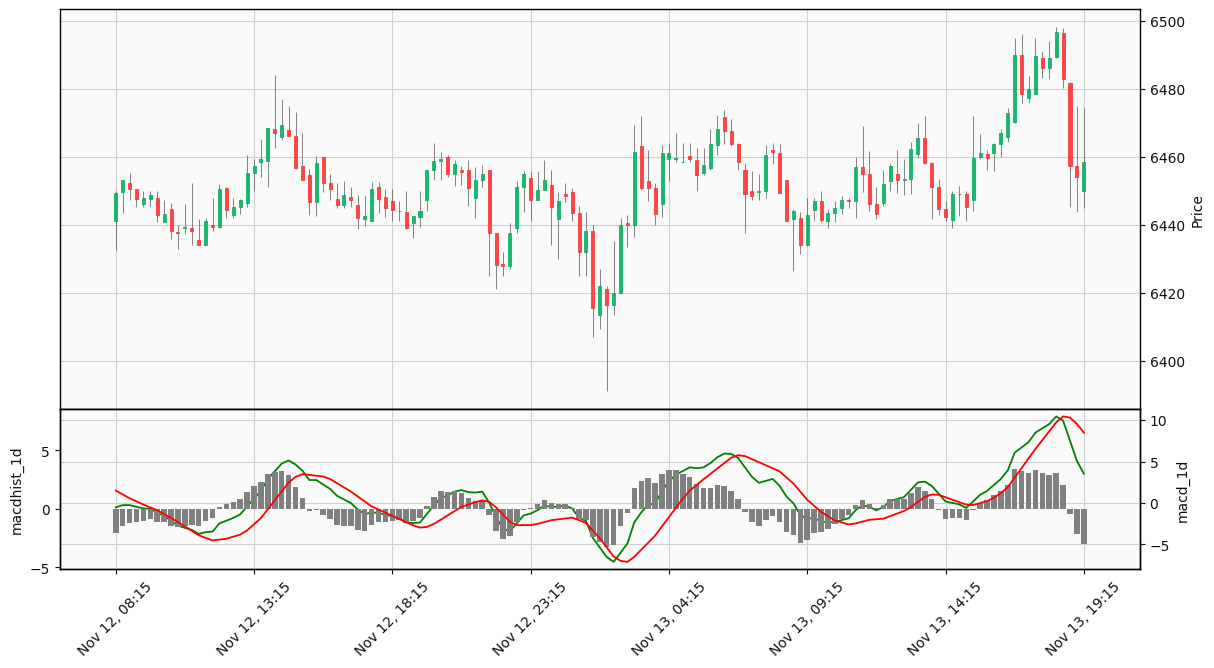

In [23]:
dataframe = df_load.copy()[:5000]

# Populate your indicator here
dataframe["macd_1d"], dataframe["macdsignal_1d"], dataframe["macdhist_1d"] = ta.MACD(
    dataframe["close"], fastperiod=12, slowperiod=26, signalperiod=9
)

# Config visualize
ind = {
    "macd_1d": {"panel": 1, "color": "green", "type": "line"},
    "macdsignal_1d": {"panel": 1, "color": "red", "type": "line"},
    "macdhist_1d": {"panel": 1, "color": "gray", "type": "bar"},
}
    

df_viz = get_middle(dataframe, random.randint(1000, 4000), 70)
plot(df_viz, ind, draw_signals=False)
del dataframe

In [ ]:
df_ = pd.DataFrame()
df_.ta.indicators()
help(pta.su)